# KE5105 - Building Electrical Consumption Forecasting

# Modelling 10 - Fine-tune model

## Summary of Findings
* Trying out the box-cox transformation on the training data

## Load libraries

In [1]:
import os
os.chdir(os.path.join(os.path.sep, 'home', 'tkokkeng', 'Documents', 'KE5105', 'ETL'))
os.getcwd()

'/home/tkokkeng/Documents/KE5105/ETL'

In [2]:
import sys
if os.path.join(os.getcwd(), 'source') not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'source'))
sys.path

['/home/tkokkeng/Documents/KE5105/ETL',
 '/home/tkokkeng/python/python367/tsfvenv/lib',
 '/home/tkokkeng/Documents/KE5105/ETL/source',
 '',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python36.zip',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/tkokkeng/.local/lib/python3.6/site-packages',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/home/tkokkeng/python/python367/tsfvenv/lib/python3.6/site-packages/IPython/extensions',
 '/home/tkokkeng/.ipython']

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import myUtilities as mu
import pickle

from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.pipeline import Pipeline

from keras import layers
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop
from keras.regularizers import l1,l2, l1_l2
from keras.callbacks import ModelCheckpoint, TensorBoard

Using TensorFlow backend.


## Load data for building AS5

In [4]:
as5_train = mu.load_data_by_bldg(['AS5'], 'imputed_train')

In [5]:
as5_train[0][1].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31616 entries, 2015-06-12 08:00:00 to 2017-03-31 23:30:00
Data columns (total 17 columns):
PWMMainIC                         30018 non-null float64
PWMEXTAS4ExBldg                   30018 non-null float64
PWMAS4LanguageCenter              30018 non-null float64
PWMCANTEEN                        30018 non-null float64
PWMStreetLight                    30018 non-null float64
BTUAS5                            30029 non-null float64
PWMMainIC_30min_avg               29985 non-null float64
PWMEXTAS4ExBldg_30min_avg         29985 non-null float64
PWMAS4LanguageCenter_30min_avg    29985 non-null float64
PWMCANTEEN_30min_avg              29985 non-null float64
PWMStreetLight_30min_avg          29985 non-null float64
BTUAS5_30min_avg                  29998 non-null float64
PWM_sumadd                        29985 non-null float64
PWM_sumsubtract                   29985 non-null float64
PWM_30min_avg                     30027 non-null float64
B

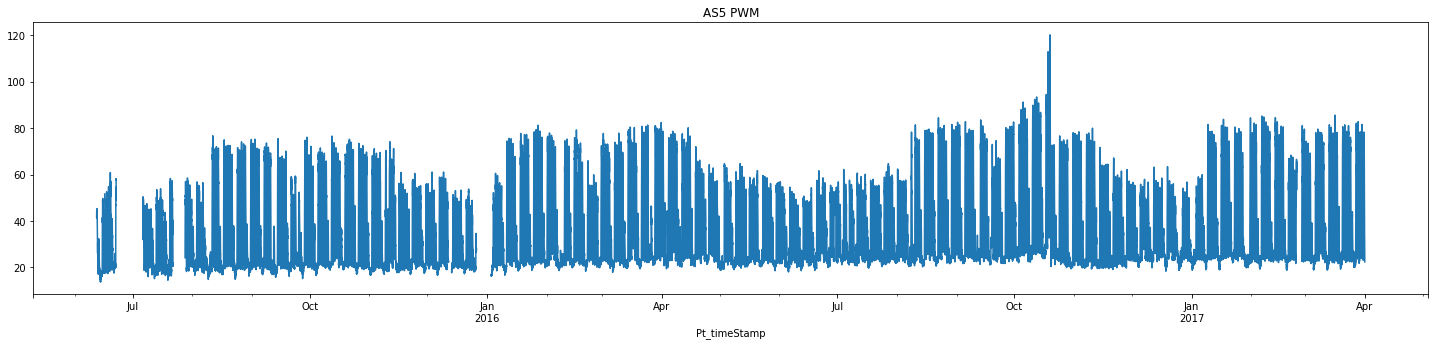

In [6]:
as5_train_df = as5_train[0][1]
as5_train_df['PWM_30min_avg'].plot(figsize=(25, 5), title='AS5 PWM')

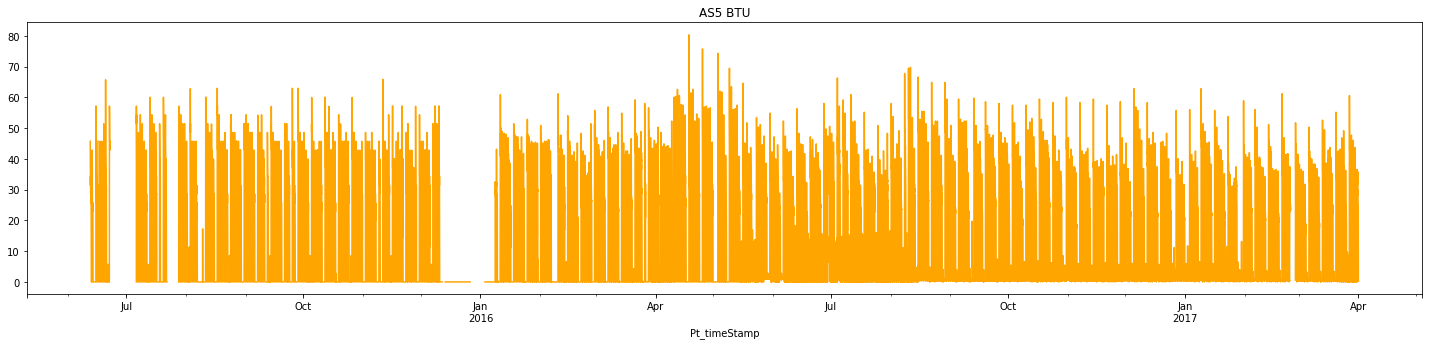

In [7]:
as5_train_df['BTU_30min_avg'].plot(figsize=(25, 5), title='AS5 BTU', color='orange')

## Transform the training data
* Remove any increasing seasonal variation from the PWM and BTU data by applying the box-cox transformation.
* Normalise the data - convert PWM and BTU values into the range 0 to 1
* Replace NaN with -1

In [8]:
s1 = as5_train_df['PWM_30min_avg']
s2 = as5_train_df['BTU_30min_avg']
print(len(s1[s1 <= 0]), len(s2[s2 <= 0]), len(s2[s2 == 0]))

0 8500 8497


In [9]:
s2[s2 < 0]

Pt_timeStamp
2015-11-30 23:30:00   -8.673617e-19
2015-12-01 00:00:00   -1.734723e-18
2016-03-01 00:00:00   -8.673617e-19
Name: BTU_30min_avg, dtype: float64

All PWM are > 0; there are zero values for BTU.

Instead of the Box-Cox transform which can only be applied to positive values, we use th Yeo-Johnson transform which can be thought of as an extension of the Box-Cox transformation. It handles both positive and negative values (more complex formulae). See https://scikit-learn.org/stable/modules/preprocessing.html#mapping-to-a-gaussian-distribution

In [10]:
# Create a transformation pipleline to prepare the training dataset for RNN.
attrbs = ['PWM_30min_avg', 'BTU_30min_avg']
my_pipeline = Pipeline([
    ('selector', mu.DataFrameSelector(attrbs)),
    ('yeo-johnson_transform', PowerTransformer(method='yeo-johnson', standardize=False, copy=True)),
    ('minmax_scaler', MinMaxScaler()),
    ('na_transform', mu.Nan_to_Num_Transformer())
])

In [11]:
as5_train_data = my_pipeline.fit_transform(as5_train_df)
as5_train_data

array([[0.69617615, 0.86408805],
       [0.70108738, 0.84907274],
       [0.71422697, 0.84874218],
       ...,
       [0.49497888, 0.27259271],
       [0.43387631, 0.05156431],
       [0.37163712, 0.05132834]])

Text(0.5, 1.0, 'Normalised PWM Training Data')

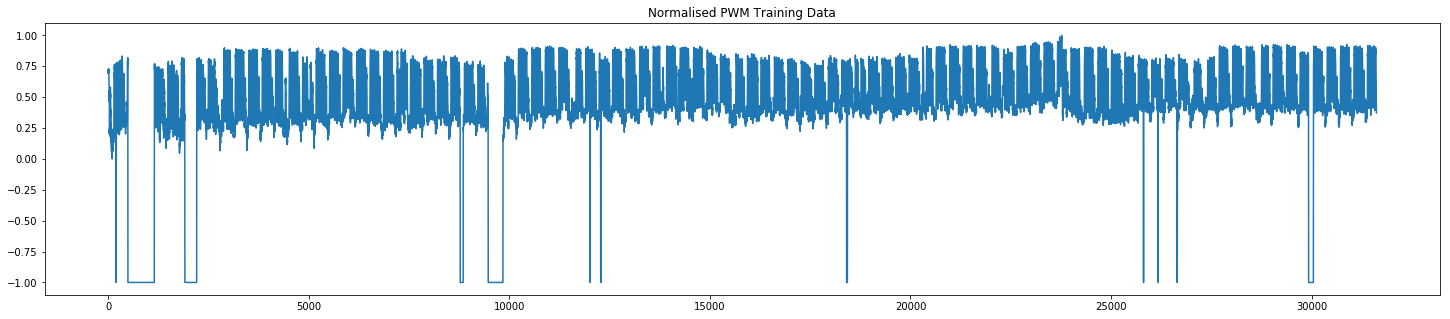

In [12]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0])
plt.title('Normalised PWM Training Data')

Text(0.5, 1.0, 'Normalised BTU Training Data')

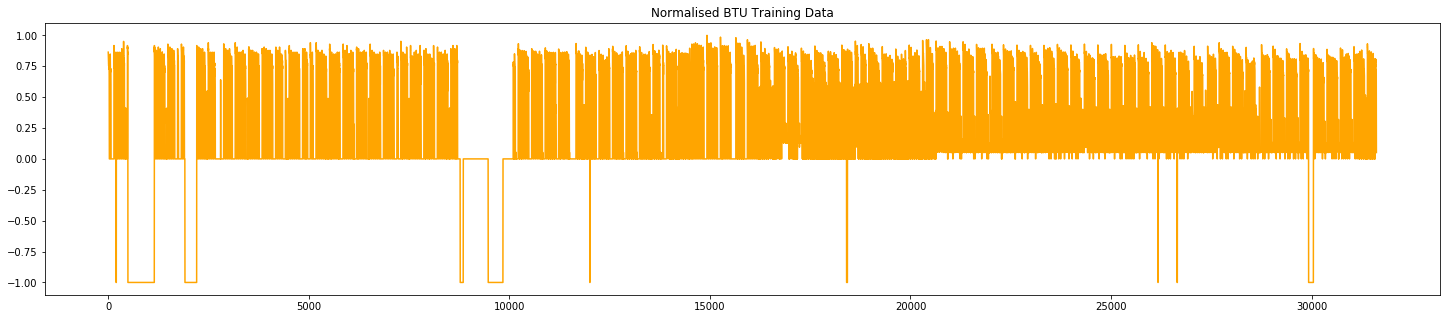

In [13]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 1], color='orange')
plt.title('Normalised BTU Training Data')

## Split a validation set out from the train set

In [14]:
as5_train_split = as5_train_data[:20000]
as5_val_split = as5_train_data[20000:]

In [15]:
print('train split = %s\nvalidation split = %s' % (as5_train_split.shape, as5_val_split.shape))

train split = (20000, 2)
validation split = (11616, 2)


## Parameters for the RNN model

Also used for generating the datasets with the lagged values 

In [16]:
lookback = 240  # 5 days; each day has 48 observations
step = 1  # sampling rate used for the lookback period
delay = 0  # 1 step ahead prediction
batch_size = 128

## 4x128 GRU, 2x32 Dense Layer Model

In [17]:

from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [18]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [19]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

train batches = 144
test batches = 88


In [23]:
histories = []

In [17]:
# Temporary - to remove after training is completed
# Load previous history
with open(os.path.join('models', 'base-yj-4x128gru-2x32dense-histories-epch300.pkl'), 'rb') as infile:
    histories = pickle.load(infile)
# Load previous model
from keras.models import load_model
model = load_model(os.path.join('models', 'base-yj-4x128gru-epch300.h5'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnngru_1 (CuDNNGRU)       (None, None, 128)         50688     
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_3 (CuDNNGRU)       (None, None, 128)         99072     
_________________________________________________________________
cu_dnngru_4 (CuDNNGRU)       (None, 128)               99072     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [20]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base-yj-4x128gru-2x32dense.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [21]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=300,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=0)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

Training start time = 2019-03-01 11:30:54.304606



Training Duration = 1:00:13.034114


In [24]:
# histories = [] # for first training session
histories.append(history.history)

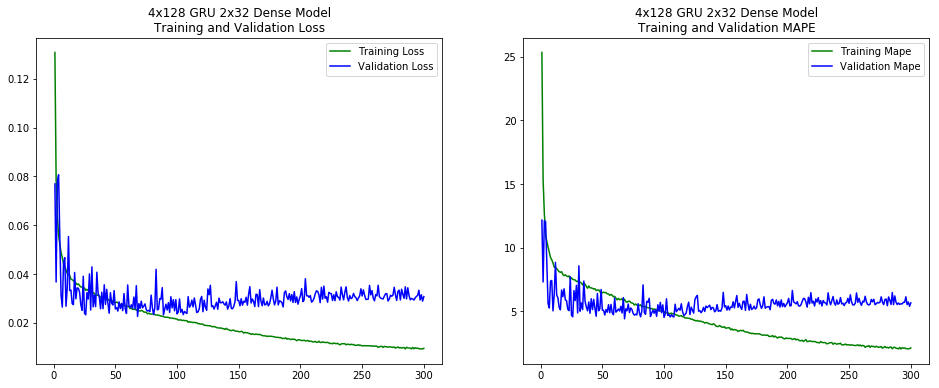

In [25]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [26]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

Train min loss = 0.009258
Validation min loss = 0.022599
Validation min epoch = 67


1st model
* Train min loss = 0.009020
* Validation min loss = 0.022909
* Validation min epoch = 96

In [26]:
# print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
#                                                (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

Train MAE = 0.959524
Validation MAE = 3.007141


In [18]:
# Load best model
best_model = load_model(os.path.join('models', 'base-yj-4x128gru-2x32dense.best.h5'))
best_model.summary()

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [21]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = best_model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

(29824, 1)

In [23]:
my_pipeline.steps

[('selector',
  DataFrameSelector(attribute_names=['PWM_30min_avg', 'BTU_30min_avg'])),
 ('yeo-johnson_transform',
  PowerTransformer(copy=True, method='yeo-johnson', standardize=False)),
 ('minmax_scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('na_transform', Nan_to_Num_Transformer(num=-1))]

In [30]:
# pt = PowerTransformer(copy=True, method='yeo-johnson', standardize=False)
# mm = MinMaxScaler(copy=True, feature_range=(0, 1))
as5_train_preds1 = np.concatenate([as5_train_preds, np.zeros((as5_train_preds.shape[0], 1))], axis=1)
as5_train_preds1.shape

(29824, 2)

In [33]:
as5_train_preds1[:5]

array([[0.74931991, 0.        ],
       [0.75790596, 0.        ],
       [0.7503221 , 0.        ],
       [0.76940286, 0.        ],
       [0.74674344, 0.        ]])

In [34]:
# as5_train_preds1 = my_pipeline.steps[1][1].inverse_transform(my_pipeline.steps[2][1].inverse_transform(as5_train_preds))
as5_train_preds1 = my_pipeline.inverse_transform(as5_train_preds1)
as5_train_preds1

array([[47.69968324,  0.        ],
       [48.81441989,  0.        ],
       [47.82751505,  0.        ],
       ...,
       [25.0476535 ,  0.        ],
       [25.0476535 ,  0.        ],
       [25.0476535 ,  0.        ]])

In [36]:
as5_train_preds1[:, 0]

array([47.69968324, 48.81441989, 47.82751505, ..., 25.0476535 ,
       25.0476535 , 25.0476535 ])

In [37]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds1[j, 0]
        j += 1
as5_train_preds_withnan.shape

(31616, 1)

In [40]:
as5_train_df['PWM_30min_avg'].values.shape

(31616,)

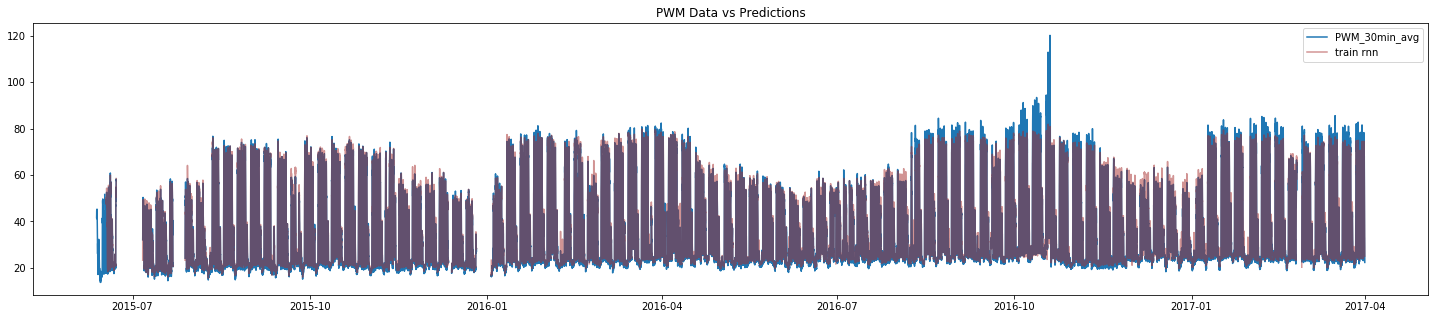

In [41]:
# plt.figure(figsize=(25, 5))
# plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
# plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
# plt.title('PWM Data vs Predictions')
# plt.legend()

plt.figure(figsize=(25, 5))
plt.plot(as5_train_df['PWM_30min_avg'])
plt.plot(as5_train_df.index, as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

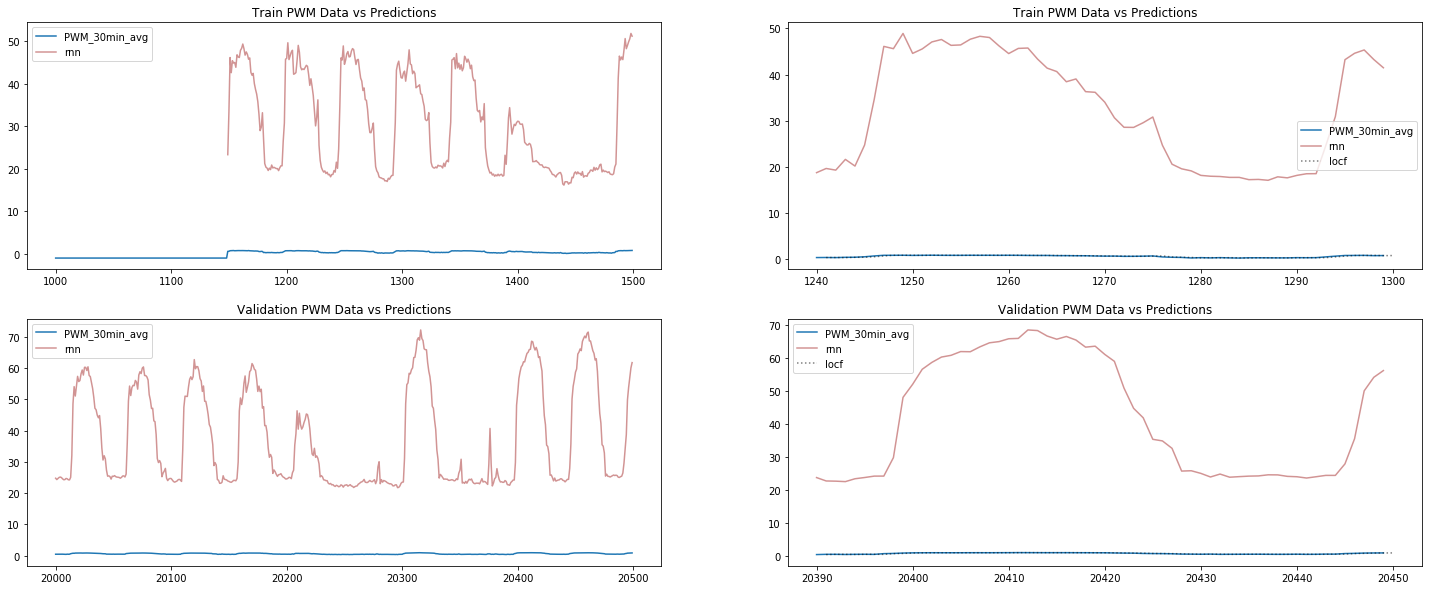

In [42]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [30]:
model.save('base-yj-4x128gru.h5')

In [31]:
with open('base-yj-4x128gru-2x32dense-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)

## ============ Ignore all below ==============

## 4x128 GRU, 2x32 Dense Layer Model (modified training)

In [ ]:
from numpy.random import seed
seed(123)

from tensorflow import set_random_seed
set_random_seed(456)

In [ ]:
model = Sequential()
model.add(layers.CuDNNGRU(128, return_sequences=True, input_shape=(None, as5_train_split.shape[-1])))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128, return_sequences=True))
model.add(layers.CuDNNGRU(128))
model.add(layers.Dense(32))
model.add(layers.Dense(32))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae', metrics=['mape'])

In [ ]:
gen_train = mu.DataGenerator(as5_train_split,
                             lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_split) - 1,
                             batch_size=batch_size, step=step)
gen_val = mu.DataGenerator(as5_val_split,
                           lookback=lookback, delay=delay, min_index=0, max_index=len(as5_val_split) - 1,
                           batch_size=batch_size, step=step)

print('train batches = %d\ntest batches = %d' % (gen_train.__len__(), gen_val.__len__()))

In [ ]:
# # Temporary - to remove after training is completed
# # Load previous history
# with open(os.path.join('models', 'base-4x128gru-2x32dense-dropout-histories.pkl'), 'rb') as infile:
#     histories = pickle.load(infile)
# # Load previous model
# from keras.models import load_model
# model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-dropout.h5'))
# model.summary()

In [ ]:
callbacks_list = [
    ModelCheckpoint(
        # filepath='base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.{epoch:02d}-{val_loss:.2f}.h5',
        filepath='base-yj-4x128gru-2x32dense.best.h5',
        monitor='val_loss',
        save_best_only=True
    ),
    TensorBoard(
        log_dir='tsb_log'
    )
]

In [ ]:
t1 = datetime.datetime.now()
print('Training start time = {}'.format(t1))
history = model.fit_generator(generator=gen_train, epochs=50,
                              callbacks=callbacks_list,
                              validation_data=gen_val,
                              workers=3, use_multiprocessing=False, shuffle=True, verbose=2)
print('\nTraining Duration = %s' % (datetime.datetime.now()-t1))

In [ ]:
histories = [] # for first training session
histories.append(history.history)

In [ ]:
train_loss = []
val_loss = []
train_mape = []
val_mape = []
for h in histories:
    for a_loss in h['loss']:
        train_loss.append(a_loss)
    for a_loss in h['val_loss']:
        val_loss.append(a_loss)
    for a_mape in h['mean_absolute_percentage_error']:
        train_mape.append(a_mape)
    for a_mape in h['val_mean_absolute_percentage_error']:
        val_mape.append(a_mape)
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.plot(epochs, train_loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation Loss')
plt.legend()
plt.subplot(122)
plt.plot(epochs, train_mape, 'g', label='Training Mape')
plt.plot(epochs, val_mape, 'b', label='Validation Mape')
plt.title('4x128 GRU 2x32 Dense Model with Dropouts\nTraining and Validation MAPE')
plt.legend()
plt.show()

In [ ]:
print('Train min loss = %f\nValidation min loss = %f\nValidation min epoch = %d' %
      (min(train_loss),
       min(val_loss),
       val_loss.index(min(val_loss))))

In [ ]:
# print('Train MAE = %f\nValidation MAE = %f' % ((min(train_loss) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min())),
#                                                (min(val_loss[-10:]) * (as5_train_df['PWM_30min_avg'].max() - as5_train_df['PWM_30min_avg'].min()))))

In [ ]:
# Load best model
best_model = load_model(os.path.join('models', 'base-4x128gru-2x32dense-wgtl1l2-1e-7-actl1-1e-7.best.h5'))
best_model.summary()

In [ ]:
gen_pred = mu.DataGenerator(as5_train_data,
                            lookback=lookback, delay=delay, min_index=0, max_index=len(as5_train_data) - 1,
                            batch_size=batch_size, step=step)
as5_train_preds = model.predict_generator(gen_pred, workers=3, use_multiprocessing=False)
as5_train_preds.shape

In [ ]:
as5_train_preds_withnan = np.full((as5_train_data.shape[0] - delay, 1), np.NaN)
j = 0
for i in range(lookback, len(as5_train_data)):
    if as5_train_data[i, 0] > -1:
        as5_train_preds_withnan[i] = as5_train_preds[j]
        j += 1
as5_train_preds_withnan.shape

In [ ]:
plt.figure(figsize=(25, 5))
plt.plot(range(as5_train_data.shape[0]), as5_train_data[:, 0], label='PWM_30min_avg')
plt.plot(range(as5_train_data.shape[0]), as5_train_preds_withnan.flatten(), color='brown', alpha=.5, label='train rnn')
plt.title('PWM Data vs Predictions')
plt.legend()

In [ ]:
plt.figure(figsize=(25, 10))
plt.subplot(221)
plt.plot(range(1000, 1500), as5_train_data[1000:1500, 0], label='PWM_30min_avg')
plt.plot(range(1000, 1500), as5_train_preds_withnan[1000:1500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(222)
plt.plot(range(1240, 1300), as5_train_data[1240:1300, 0], label='PWM_30min_avg')
plt.plot(range(1240, 1300), as5_train_preds_withnan[1240:1300].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(1241, 1301), as5_train_data[1240:1300, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Train PWM Data vs Predictions')
plt.legend()
plt.subplot(223)
plt.plot(range(20000, 20500), as5_train_data[20000:20500, 0], label='PWM_30min_avg')
plt.plot(range(20000, 20500), as5_train_preds_withnan[20000:20500, :].flatten(), color='brown', alpha=.5, label='rnn')
plt.title('Validation PWM Data vs Predictions')
plt.legend()
plt.subplot(224)
plt.plot(range(20390, 20450), as5_train_data[20390:20450, 0], label='PWM_30min_avg')
plt.plot(range(20390, 20450), as5_train_preds_withnan[20390:20450].flatten(), color='brown', alpha=.5, label='rnn')
plt.plot(range(20391, 20451), as5_train_data[20390:20450, 0], color='black', alpha=.5, label='locf', linestyle=':')  ## locf is data with lag -1 
plt.title('Validation PWM Data vs Predictions')
plt.legend()

In [ ]:
model.save('base-fg-4x128gru-2x32dense.h5')

In [ ]:
with open('base-fg-4x128gru-2x32dense-histories.pkl', 'wb') as outfile:
    pickle.dump(histories, outfile)